In [7]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from netCDF4 import Dataset

from sklearn.preprocessing import MinMaxScaler


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

import pickle
import matplotlib.pyplot as plt

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [3]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

In [6]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc","../../nc/air.mon.mean.nc","../../nc/sst.mnmean.nc"]
code = ["precip", "pres", "air", "sst"]
missing = [-9.96921e+36, -9.96921e+36, -9.96921e+36,-9.96921e+36]
n_components = [87, 64, 82, 76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]
               
    data = pd.DataFrame(result)

    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)
    
pres_name  = []
for i in range(n_components[1]):
    pres_name.append("PRES_%d"%i)
    
sat_name  = []
for i in range(n_components[2]):
    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[3]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name + pres_name + sat_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))
result_precip = np.array(df_cluster[0])
result_pres = np.array(df_cluster[1])
result_sat = np.array(df_cluster[2])
result_sst = np.array(df_cluster[3])


result = np.concatenate((result_extremes,result_precip, result_pres, result_sat, result_sst), axis=1)
result = np.array(result)

KeyboardInterrupt: 

In [8]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()

In [9]:
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [7]:
#results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

In [5]:
results = load_obj("results")

In [6]:
q_matrix = np.load("q_matrix.npy")

In [10]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 42 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.587
        (PRECIP_1 -1): pval = 0.00023 | val = 0.196
        (SAT_70 -1): pval = 0.00055 | val = 0.188
        (PRECIP_39 -1): pval = 0.00068 | val = 0.185
        (SAT_62 -1): pval = 0.00182 | val = -0.172
        (PRECIP_5 -1): pval = 0.00197 | val = 0.171
        (SST_60 -2): pval = 0.00210 | val = -0.168
        (PRECIP_49 -2): pval = 0.00280 | val = -0.165
        (PRES_29 -1): pval = 0.00375 | val = 0.158
        (PRECIP_13 -1): pval = 0.00508 | val = -0.155
        (PRES_32 -2): pval = 0.00491 | val = -0.154
        (PRES_32 -1): pval = 0.00492 | val = 0.154
        (PRECIP_11 -1): pval = 0.01009 | val = 0.142
        (PRECIP_78 -2): pval = 0.01073 | val = -0.142
        (SST_29 -1): pval = 0.01012 | val = -0.141
        (PRECIP_43 -2): pval = 0.01330 | val = -0.139
        (SST_41 -2): pval = 0.01254 | val = 0.138
        (PRES_46 -1): pval = 0.01

In [11]:
#q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.587

    Variable PRECIP_0 has 1 link(s):
        (SAT_7 -1): pval = 0.00002 | qval = 0.02883 | val = -0.236

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 1 link(s):
        (PRECIP_60 -1): pval = 0.00001 | qval = 0.01316 | val = -0.242

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 0 link(s):

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 1 link(s):
        (PRECIP_51 -

In [8]:
count = np.load("../spiCount/count_5.npy")

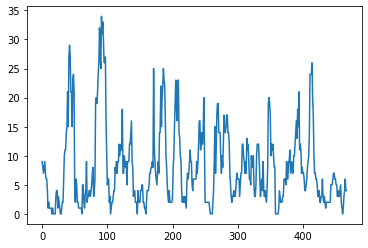

In [9]:
plt.plot(count)

In [10]:
name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


In [11]:
result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [12]:
results = load_obj("results_5")

q_matrix = np.load("q_matrix_5.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 63 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.444
        (SST_74 -1): pval = 0.00028 | val = -0.208
        (n_extremes -12): pval = 0.00049 | val = -0.197
        (SST_0 -3): pval = 0.00034 | val = 0.196
        (SST_35 -12): pval = 0.00063 | val = -0.196
        (SST_71 -12): pval = 0.00067 | val = 0.195
        (SST_39 -5): pval = 0.00168 | val = -0.181
        (SST_6 -5): pval = 0.00155 | val = 0.179
        (SST_49 -11): pval = 0.00216 | val = 0.174
        (SST_0 -6): pval = 0.00149 | val = 0.174
        (SST_56 -11): pval = 0.00545 | val = -0.162
        (SST_10 -3): pval = 0.00430 | val = 0.162
        (SST_50 -8): pval = 0.00540 | val = 0.161
        (SST_62 -1): pval = 0.00454 | val = 0.160
        (SST_56 -8): pval = 0.00667 | val = -0.158
        (SST_7 -11): pval = 0.00554 | val = 0.157
        (SST_11 -11): pval = 0.00723 | val = 0.154
        (SST_32 -1): pval = 0.00835 | val = -0.152
  

In [39]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.444

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.550

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.590

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.596

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.546

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.508

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.546

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.573

    Variable SST_7 has 1 link(s):
        (SST_7 -1): pval = 0.00000 | qval = 0.00000 | val = 0.483

    Variable SST_8 has 1 link(s):
       

In [5]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc"]
code = ["precip"]
missing = [-9.96921e+36]
n_components = [87]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pre = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pre), axis=1)
result = np.array(result)

In [6]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [7]:
results = load_obj("results_pre")

q_matrix = np.load("q_matrix_pre.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 68 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.589
        (PRECIP_3 -1): pval = 0.00037 | val = -0.226
        (PRECIP_71 -6): pval = 0.00166 | val = 0.201
        (PRECIP_2 -1): pval = 0.00161 | val = -0.201
        (PRECIP_0 -1): pval = 0.00282 | val = -0.185
        (PRECIP_6 -1): pval = 0.00355 | val = -0.184
        (PRECIP_6 -8): pval = 0.00438 | val = -0.183
        (PRECIP_51 -11): pval = 0.00537 | val = -0.181
        (PRECIP_70 -1): pval = 0.00613 | val = -0.177
        (PRECIP_54 -5): pval = 0.00732 | val = 0.173
        (PRECIP_8 -6): pval = 0.00733 | val = -0.172
        (PRECIP_22 -7): pval = 0.00895 | val = 0.170
        (PRECIP_31 -5): pval = 0.00825 | val = -0.170
        (PRECIP_23 -2): pval = 0.00846 | val = -0.168
        (PRECIP_46 -11): pval = 0.01001 | val = -0.167
        (PRECIP_52 -3): pval = 0.01023 | val = 0.167
        (PRECIP_41 -7): pval = 0.01090 | val = -0.166
        (P

In [8]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.589

    Variable PRECIP_0 has 0 link(s):

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 0 link(s):

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 1 link(s):
        (PRECIP_86 -10): pval = 0.00000 | qval = 0.00601 | val = 0.345

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 0 link(s):

    Variable PRECIP_18 has 0 link(s):

    Variable PRECIP_19 has 0 link(s):

    Vari

In [6]:
name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[0]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sat_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sat = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sat), axis=1)
result = np.array(result)

In [7]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [8]:
results = load_obj("results_sat")

q_matrix = np.load("q_matrix_sat.npy")

In [9]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)




## Significant links at alpha = 0.05:

    Variable n_extremes has 52 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.501
        (SAT_22 -2): pval = 0.00021 | val = 0.223
        (SAT_59 -6): pval = 0.00041 | val = -0.215
        (SAT_64 -12): pval = 0.00160 | val = 0.196
        (SAT_38 -2): pval = 0.00368 | val = -0.179
        (SAT_52 -4): pval = 0.00398 | val = 0.178
        (SAT_13 -5): pval = 0.00572 | val = 0.174
        (SAT_62 -1): pval = 0.00624 | val = -0.169
        (SAT_63 -3): pval = 0.00815 | val = 0.162
        (SAT_80 -4): pval = 0.01095 | val = -0.160
        (SAT_14 -1): pval = 0.00861 | val = 0.160
        (SAT_29 -6): pval = 0.01090 | val = 0.159
        (SAT_49 -8): pval = 0.01192 | val = -0.155
        (SAT_66 -6): pval = 0.01544 | val = -0.152
        (SAT_35 -1): pval = 0.01409 | val = -0.152
        (SAT_52 -8): pval = 0.01579 | val = 0.151
        (SAT_55 -7): pval = 0.01798 | val = 0.148
        (SAT_24 -6): pval = 0.01680 | val = 0.146
        

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.501

    Variable SAT_0 has 1 link(s):
        (SAT_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.630

    Variable SAT_1 has 2 link(s):
        (SAT_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.475
        (SAT_43 -3): pval = 0.00000 | qval = 0.00403 | val = 0.298

    Variable SAT_2 has 1 link(s):
        (SAT_2 -1): pval = 0.00000 | qval = 0.01945 | val = 0.280

    Variable SAT_3 has 1 link(s):
        (SAT_3 -1): pval = 0.00000 | qval = 0.02694 | val = 0.282

    Variable SAT_4 has 0 link(s):

    Variable SAT_5 has 0 link(s):

    Variable SAT_6 has 1 link(s):
        (SAT_32 -4): pval = 0.00000 | qval = 0.03322 | val = 0.289

    Variable SAT_7 has 0 link(s):

    Variable SAT_8 has 0 link(s):

    Variable SAT_9 has 0 link(s):

    Variable SAT_10 has 0 link(s):

    Variable SAT_11 has 0 link(s):

    Variable SAT_12 has 0 lin

In [11]:
name = ["../../nc/pres.mon.mean.nc"]
code = ["pres"]
missing = [-9.96921e+36]
n_components = [64]


df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

pres_name  = []
for i in range(n_components[0]):
    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[0]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + pres_name

In [12]:
result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pres = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pres), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
results = load_obj("results_pres")

q_matrix = np.load("q_matrix_pres.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 49 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.618
        (PRES_25 -10): pval = 0.00007 | val = 0.253
        (PRES_1 -1): pval = 0.00074 | val = -0.207
        (PRES_62 -7): pval = 0.00105 | val = -0.205
        (n_extremes -12): pval = 0.00117 | val = -0.204
        (PRES_11 -2): pval = 0.00265 | val = -0.190
        (PRES_49 -2): pval = 0.00303 | val = -0.178
        (PRES_5 -2): pval = 0.00638 | val = -0.169
        (PRES_24 -1): pval = 0.00653 | val = -0.169
        (PRES_58 -10): pval = 0.00729 | val = -0.169
        (PRES_50 -3): pval = 0.00516 | val = 0.169
        (PRES_57 -2): pval = 0.00686 | val = 0.167
        (PRES_41 -8): pval = 0.00776 | val = 0.166
        (PRES_61 -7): pval = 0.00835 | val = -0.164
        (PRES_62 -8): pval = 0.01142 | val = 0.160
        (PRES_37 -2): pval = 0.01456 | val = 0.153
        (PRES_61 -3): pval = 0.01320 | val = -0.152
        (PRES_49 -10): pval = 0.0134

In [15]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.618

    Variable PRES_0 has 0 link(s):

    Variable PRES_1 has 0 link(s):

    Variable PRES_2 has 0 link(s):

    Variable PRES_3 has 0 link(s):

    Variable PRES_4 has 0 link(s):

    Variable PRES_5 has 0 link(s):

    Variable PRES_6 has 1 link(s):
        (PRES_53 -9): pval = 0.00000 | qval = 0.01876 | val = -0.306

    Variable PRES_7 has 0 link(s):

    Variable PRES_8 has 0 link(s):

    Variable PRES_9 has 0 link(s):

    Variable PRES_10 has 0 link(s):

    Variable PRES_11 has 0 link(s):

    Variable PRES_12 has 0 link(s):

    Variable PRES_13 has 0 link(s):

    Variable PRES_14 has 0 link(s):

    Variable PRES_15 has 0 link(s):

    Variable PRES_16 has 0 link(s):

    Variable PRES_17 has 0 link(s):

    Variable PRES_18 has 0 link(s):

    Variable PRES_19 has 0 link(s):

    Variable PRES_20 has 0 link(s):

    Variable 

In [12]:
result_spi = np.load("df_cluster_spi_global.npy")

In [13]:
level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 46

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [14]:
result_sst = np.array(df_cluster[0])


result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

In [15]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [16]:
results = load_obj("results_SPI_global")

q_matrix = np.load("q_matrix_SPI_global.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 95 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | val = -0.306
        (SST_34 -5): pval = 0.00020 | val = -0.207
        (SST_73 -10): pval = 0.00036 | val = 0.196
        (SST_1 -1): pval = 0.00057 | val = 0.185
        (SPI_28 -12): pval = 0.00094 | val = 0.181
        (SST_52 -4): pval = 0.00195 | val = -0.171
        (SPI_41 -7): pval = 0.00243 | val = 0.165
        (SST_4 -7): pval = 0.00327 | val = -0.162
        (SST_64 -2): pval = 0.00449 | val = -0.157
        (SPI_37 -8): pval = 0.00503 | val = 0.152
        (SST_46 -1): pval = 0.00627 | val = -0.151
        (SPI_30 -2): pval = 0.00557 | val = 0.150
        (SPI_33 -11): pval = 0.00560 | val = 0.150
        (SST_11 -8): pval = 0.00729 | val = -0.149
        (SPI_19 -4): pval = 0.00596 | val = 0.148
        (SPI_18 -6): pval = 0.00616 | val = 0.147
        (SPI_34 -12): pval = 0.00673 | val = 0.147
        (SST_64 -

In [17]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 2 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | qval = 0.00001 | val = -0.306

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.649
        (SPI_1 -12): pval = 0.00000 | qval = 0.00029 | val = -0.275

    Variable SPI_2 has 4 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.661
        (SPI_2 -12): pval = 0.00000 | qval = 0.00001 | val = -0.315
        (SPI_12 -3): pval = 0.00001 | qval = 0.01597 | val = 0.242
        (SPI_36 -12): pval = 0.00003 | qval = 0.02910 | val = 0.227

    Variable SPI_3 has 2 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.634
        (SPI_3 -12): pval = 0.00005 | qval = 0.04797 | val = -0.226

    Variable SPI_4 has 2 link(s):
        (SPI_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.647
        (SPI_4 -12): pval = 0.00000 | qval = 0.00

In [15]:
result_spi = np.load("ET_gamma = np.load("Cal_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))


name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_cal")

q_matrix = np.load("q_matrix_cal.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)")

In [16]:
level = 12
emporal_limits = {"time_min":datetime(1974, 1, 1, 0, 0),"time_max":datetime(2012, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 9

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [17]:
result_sst = np.array(df_cluster[0])


result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_SPI")

q_matrix = np.load("q_matrix_SPI.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 756 and the array at index 1 has size 468

In [ ]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)

In [34]:
level = 12
temporal_limits = {"time_min":datetime(1950, 1, 1, 0, 0),"time_max":datetime(2012, 12, 1, 0, 0) }

In [35]:
count = np.load("count_SPI.npy")

In [36]:
name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [37]:
results = load_obj("results_SPI_whole")

q_matrix = np.load("q_matrix_SPI_whole.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 51 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.582
        (n_extremes -12): pval = 0.00012 | val = -0.160
        (SST_10 -3): pval = 0.00050 | val = -0.143
        (SST_12 -3): pval = 0.00157 | val = 0.131
        (SST_17 -12): pval = 0.00337 | val = 0.123
        (SST_29 -11): pval = 0.00446 | val = -0.121
        (SST_9 -11): pval = 0.00533 | val = 0.117
        (SST_45 -6): pval = 0.00566 | val = 0.117
        (SST_71 -11): pval = 0.00538 | val = -0.117
        (SST_27 -8): pval = 0.00554 | val = 0.116
        (SST_15 -9): pval = 0.00686 | val = 0.114
        (SST_53 -6): pval = 0.00808 | val = -0.112
        (SST_65 -8): pval = 0.00835 | val = 0.111
        (SST_67 -6): pval = 0.00854 | val = 0.110
        (SST_72 -7): pval = 0.00958 | val = -0.108
        (SST_68 -6): pval = 0.01091 | val = -0.107
        (SST_29 -7): pval = 0.01173 | val = -0.107
        (SST_17 -3): pval = 0.01095 | val = -0.107

In [38]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.582

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.626

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.665

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.602

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.609

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.617

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.531

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.637

    Variable SST_7 has 1 link(s):
        (SST_7 -1): pval = 0.00000 | qval = 0.00000 | val = 0.535

    Variable SST_8 has 1 link(s):
       

# Global SPI

In [5]:
ET_gamma = np.load("World_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))


name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_cal")

q_matrix = np.load("q_matrix_cal.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 53 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.444
        (SST_40 -7): pval = 0.00001 | val = -0.250
        (n_extremes -12): pval = 0.00056 | val = -0.199
        (SST_65 -10): pval = 0.00189 | val = 0.181
        (SST_68 -3): pval = 0.00383 | val = 0.167
        (SST_17 -10): pval = 0.00540 | val = 0.164
        (SST_57 -1): pval = 0.00488 | val = -0.162
        (SST_72 -7): pval = 0.00538 | val = -0.162
        (SST_0 -11): pval = 0.00441 | val = -0.160
        (SST_47 -11): pval = 0.00596 | val = -0.159
        (SST_22 -6): pval = 0.00689 | val = 0.156
        (SST_49 -3): pval = 0.00646 | val = 0.156
        (SST_72 -5): pval = 0.00727 | val = 0.155
        (SST_19 -5): pval = 0.00798 | val = 0.152
        (SST_18 -3): pval = 0.00825 | val = -0.152
        (SST_51 -8): pval = 0.01145 | val = 0.147
        (SST_7 -12): pval = 0.01198 | val = 0.145
        (SST_11 -4): pval = 0.01182 | val = 0.144
 